In [1]:
!pip install kaggle
!mkdir -p ~/.kaggle


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jhwang1","key":"6f80ce7088b59bada7f5c3746ca60dbe"}'}

In [3]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d splcher/animefacedataset


 95% 375M/395M [00:08<00:00, 32.2MB/s]
100% 395M/395M [00:08<00:00, 47.4MB/s]


In [0]:
#Unzip the dataset downloaded from kaggle
from zipfile import ZipFile
with ZipFile('animefacedataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in the data directory
   zipObj.extractall('./data/')

In [0]:
import os
import cv2
from imutils import paths
def load_data():
  X = []
  filePaths = sorted(list(paths.list_images(os.path.join(os.getcwd(),'data'))))
  filePaths = filePaths[:1000]
  print(len(filePaths))
  for file_i in filePaths:
    print('read:',file_i)
    img = cv2.imread(file_i)
    img = cv2.resize(img, (32,32))
    X.append(img)
  X = np.array(X)
  X = X/255.0
  return X



In [6]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, ZeroPadding2D,UpSampling2D,Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model,Sequential
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
import numpy as np
import tensorflow as tf

print("[INFO] Load Dataset")
#  
X = load_data()
#Selecting a single class images 

#X = X[y.flatten() == 8] 
print(X.shape)
im_shape = (32,32,3)
# Build Generative model ...
def build_generator(latent_dims):
  model = Sequential()

  model.add(Dense(128*8*8, activation="relu", input_dim = latent_dims))
  model.add(Reshape((8,8,128)))

  model.add(UpSampling2D())

  model.add(Conv2D(128, kernel_size=3,padding="same"))
  model.add(BatchNormalization(momentum=0.7))
  model.add(Activation("relu"))

  model.add(UpSampling2D())

  model.add(Conv2D(64, kernel_size=3,padding="same"))
  model.add(BatchNormalization(momentum=0.7))
  model.add(Activation("relu"))



  model.add(Conv2D(3, kernel_size=3,padding="same"))
  model.add(Activation("tanh"))

  model.summary()
  #Generating output image
  noise = Input(shape=(latent_dims,))
  image = model(noise)

  return Model(noise,image)

Using TensorFlow backend.


[INFO] Load Dataset
1000
read: /content/data/images/0_2000.jpg
read: /content/data/images/10000_2004.jpg
read: /content/data/images/10001_2004.jpg
read: /content/data/images/10002_2004.jpg
read: /content/data/images/10003_2004.jpg
read: /content/data/images/10004_2004.jpg
read: /content/data/images/10005_2004.jpg
read: /content/data/images/10006_2004.jpg
read: /content/data/images/10007_2004.jpg
read: /content/data/images/10008_2004.jpg
read: /content/data/images/10009_2004.jpg
read: /content/data/images/1000_2000.jpg
read: /content/data/images/10010_2004.jpg
read: /content/data/images/10011_2004.jpg
read: /content/data/images/10012_2004.jpg
read: /content/data/images/10013_2004.jpg
read: /content/data/images/10014_2004.jpg
read: /content/data/images/10015_2004.jpg
read: /content/data/images/10016_2004.jpg
read: /content/data/images/10017_2004.jpg
read: /content/data/images/10018_2004.jpg
read: /content/data/images/10019_2004.jpg
read: /content/data/images/1001_2000.jpg
read: /content/

In [0]:
# Build discriminator
def build_discrim(im_shape):
  #Conv layer
  model = Sequential()

  model.add(Conv2D(32,kernel_size=3,strides=2,input_shape=im_shape,padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, kernel_size=3, strides=2, padding="same")) 
  model.add(ZeroPadding2D(padding=((0,1),(0,1)))) 
  model.add(BatchNormalization(momentum=0.82)) 
  model.add(LeakyReLU(alpha=0.25)) 
  model.add(Dropout(0.25)) 

  model.add(Conv2D(128, kernel_size=3, strides=2, padding="same")) 
  model.add(BatchNormalization(momentum=0.82)) 
  model.add(LeakyReLU(alpha=0.25)) 
  model.add(Dropout(0.25))

  model.add(Conv2D(256, kernel_size=3, strides=2, padding="same")) 
  model.add(ZeroPadding2D(padding=((0,1),(0,1)))) 
  model.add(BatchNormalization(momentum=0.82)) 
  model.add(LeakyReLU(alpha=0.25)) 
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(1,activation='sigmoid'))

  image = Input(shape=im_shape)
  valid = model(image)

  return Model(image,valid)

In [8]:
latent_dims = 100
discrim = build_discrim(im_shape)
discrim.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])

discrim.trainable = False
discrim.summary()

gen = build_generator(latent_dims)
gen.summary()
z= Input(shape=(latent_dims,))
image = gen(z)

valid = discrim(image)

combined_network = Model(z,valid)
combined_network.compile(loss='binary_crossentropy', 
                         optimizer=Adam(0.0002,0.5)) 

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 394305    
Total params: 787,714
Trainable params: 393,409
Non-trainable params: 394,305
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 128)       0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 32, 32, 128)      

In [10]:
combined_network.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 32, 32, 3)         1051267   
_________________________________________________________________
model_1 (Model)              (None, 1)                 394305    
Total params: 1,445,572
Trainable params: 1,050,883
Non-trainable params: 394,689
_________________________________________________________________


In [0]:
import matplotlib.pyplot as plt

def display_images(): 
        r, c = 4,4
        noise = np.random.normal(0, 1, (r * c,latent_dims)) 
        generated_images = gen.predict(noise) 
  
        #Scaling the generated images 
        generated_images = 0.5 * generated_images + 0.5
  
        fig, axs = plt.subplots(r, c) 
        count = 0
        for i in range(r): 
            for j in range(c): 
                axs[i,j].imshow(generated_images[count, :,:,]) 
                axs[i,j].axis('off') 
                count += 1
        plt.show() 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 1
Generator loss:  0.57289594
Discriminator loss:  [2.277864 0.      ]


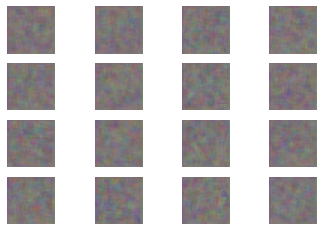

In [0]:
from tqdm import tqdm_notebook as tqdm
num_epochs = 15000
batch_size = 32
display_interval = 1000
losses = []

#Normalize the input
#X = (X/127.5) - 1

valid = np.ones((batch_size,1))

valid += 0.05* np.random.random(valid.shape)
fake = np.zeros((batch_size,1))
fake += 0.05* np.random.random(fake.shape)

for ep in tqdm(range(num_epochs)):
  #Sampling a random half of images 
            index = np.random.randint(0, X.shape[0], batch_size) 
            images = X[index] 
  
            #Sampling noise and generating a batch of new images 
            noise = np.random.normal(0, 1, (batch_size, latent_dims)) 
            generated_images = gen.predict(noise) 
              
  
            #Training the discriminator to detect more accurately 
            #whether a generated image is real or fake 
            discm_loss_real = discrim.train_on_batch(images, valid) 
            discm_loss_fake = discrim.train_on_batch(generated_images, fake) 
            discm_loss = 0.5 * np.add(discm_loss_real, discm_loss_fake) 
              
            #Training the Generator 
  
            #Training the generator to generate images 
            #which pass the authenticity test 
            genr_loss = combined_network.train_on_batch(noise, valid) 
            
            #Tracking the progress                 
            if ep % display_interval == 0: 
                 print('epoch:',ep+1)
                 print('Generator loss: ',genr_loss)
                 print('Discriminator loss: ',discm_loss)
                 display_images() 